In [1]:
# noise sources: stellar flux variations, orientiation angle noise, telescope polarization

# fitting params: (albedo*polarization fraction), {Omega, inclination} or {apparent inc, orbAxisAng angle}
# additional real params: Q+U+V offsets

# need to do a disk integration since there isn't a single path that light takes
#    - need to account for angles spanning the visible portion of the illuminated hemisphere

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import EPPE_Simulator as eppe
import astropy.constants as const

# from EPPE_Simulator import cross_match
# cross_match.cross_match_tables()

In [3]:
expTime = 1
intTime = 30*24.

randomOrientation = False
albedo = 0.1#'theo'
polEff = 1.
filt = 'V'

highPassSize = 20

In [4]:
systems = eppe.Systems(load=True, polEff=polEff, randomOrientation=randomOrientation, albedo=albedo)

systems.catalogue['albedo'][systems.catalogue['rp']/const.R_earth.value<4.] = 0.3

# mission = eppe.EPPE(systems, rad=0.8, filt=filt) # POMM
mission = eppe.EPPE(systems, filt=filt) # EPPE

In [5]:
teq = systems.catalogue['teq']
rps = systems.catalogue['rp']

amps = mission.compute_amps(expTime)
noise = mission.compute_noise(expTime)
SNRs = mission.compute_SNR(amps=amps, noise=noise)

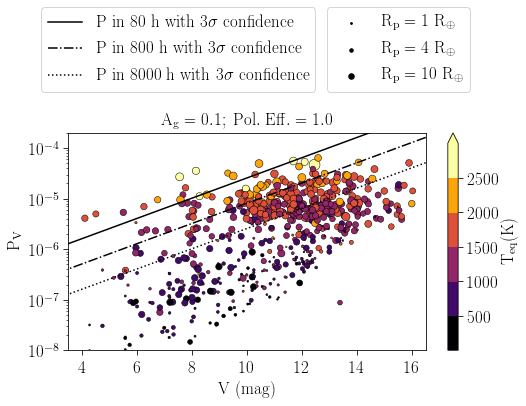

In [6]:
fig = plt.figure(figsize=(8,4))

cmap = plt.get_cmap('inferno', 6)

# good = rps/const.R_earth.value < 4.
# good = teq < 2000
good = teq > -1

optMag = systems.catalogue['optMag']

plt.scatter(x=optMag[good], y=amps[good], c=teq[good], s=3*rps[good]/const.R_earth.value, cmap=cmap, vmin=0, vmax=3000, edgecolor='k', linewidth=0.5)
cbar = plt.colorbar(label=r'$\rm T_{eq} (K)$', extend='max')
cbar.set_ticks([500,1000,1500,2000,2500])

noiseFloor = 0#1e-7*3*np.sqrt(2)
x = np.linspace(0,20,1000)

tint = 80
limit = 1/np.sqrt(tint/expTime)*3*np.sqrt(2)*noise[np.argmin(optMag)]*(10**((x-np.min(optMag))/5))
limit += noiseFloor
plt.plot(x, limit, c='k', ls='-', label=r'$\rm P~in~'+str(tint)+'~h~with~3\sigma~confidence$')

tint = 800
limit = 1/np.sqrt(tint/expTime)*3*np.sqrt(2)*noise[np.argmin(optMag)]*(10**((x-np.min(optMag))/5))
limit += noiseFloor
plt.plot(x, limit, c='k', ls='-.', label=r'$\rm P~in~'+str(tint)+'~h~with~3\sigma~confidence$')

tint = 8000
limit = 1/np.sqrt(tint/expTime)*3*np.sqrt(2)*noise[np.argmin(optMag)]*(10**((x-np.min(optMag))/5))
limit += noiseFloor
plt.plot(x, limit, c='k', ls='dotted', label=r'$\rm P~in~'+str(tint)+'~h~with~3\sigma~confidence$')


plt.yscale('log')
plt.ylim(1e-8,2e-4)
plt.xlim(3.5,16.5)
plt.xticks([4,6,8,10,12,14,16])

plt.xlabel(r'$\rm V~(mag)$')
plt.ylabel(r'$\rm P_'+filt+'$')
if albedo != 'theo':
    plt.title(r'$\rm A_g = '+str(albedo)+';~Pol.~Eff. = '+str(polEff)+'$')
else:
    plt.title(r'$\rm Predicted~A_g;~Pol.~Eff. = '+str(polEff)+'$')

rp = 1
d1 = plt.scatter(x=1000, y=1e-12, c='k', s=3*rp, label=r'$\rm R_p = '+str(rp)+'~R_{\oplus}$')
rp = 4
d2 = plt.scatter(x=1000, y=1e-12, c='k', s=3*rp, label=r'$\rm R_p = '+str(rp)+'~R_{\oplus}$')
rp = 10
d3 = plt.scatter(x=1000, y=1e-12, c='k', s=3*rp, label=r'$\rm R_p = '+str(rp)+'~R_{\oplus}$')

handles, labels = plt.gca().get_legend_handles_labels()
legend1 = plt.legend(handles[:3], labels[:3], loc=3, bbox_to_anchor=(-0.1,1.15))
legend2 = plt.legend(handles[3:], labels[3:], loc=3, bbox_to_anchor=(0.7,1.15))
plt.gca().add_artist(legend1)

plt.show()

/home/taylor/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in true_divide


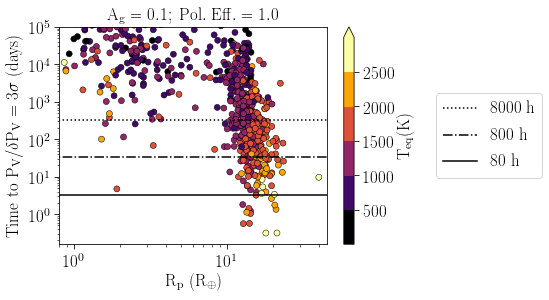

In [7]:
tint = 1
limit = 1/np.sqrt(tint/expTime)*3*np.sqrt(2)*noise[np.argmin(optMag)]*(10**((optMag[good]-np.min(optMag))/5))

x = rps[good]/const.R_earth.value
y = (limit/amps[good])**2/24.

cmap = plt.get_cmap('inferno', 6)
plt.scatter(x, y, c=teq[good], cmap=cmap, vmin=0, vmax=3000, edgecolor='k', linewidth=0.5)
cbar = plt.colorbar(label=r'$\rm T_{eq} (K)$', extend='max')
cbar.set_ticks([500,1000,1500,2000,2500])

plt.plot([0,1e5], [8000/24.,8000/24.], c='k', ls='dotted', label=r'$\rm 8000~h$')
plt.plot([0,1e5], [800/24.,800/24.], c='k', ls='-.', label=r'$\rm 800~h$')
plt.plot([0,1e5], [80/24.,80/24.], c='k', ls='-', label=r'$\rm 80~h$')

plt.yscale('log')
plt.xscale('log')
plt.ylim(np.nanmin(y[y>0])/2.,1e5)
plt.xlim(8e-1,45)

if albedo != 'theo':
    plt.title(r'$\rm A_g = '+str(albedo)+';~Pol.~Eff. = '+str(polEff)+'$')
else:
    plt.title(r'$\rm Predicted~A_g;~Pol.~Eff. = '+str(polEff)+'$')
plt.ylabel(r'$\rm Time~to~P_'+filt+'/\delta P_'+filt+'=3\sigma~(days)$')
plt.xlabel(r'$\rm R_p~(R_{\oplus})$')

plt.legend(loc=6, bbox_to_anchor=(1.375,0.5))

plt.show()

In [8]:
nPlanets = 5
nEarths = 4
fullNames = np.array([])
fullInds = np.array([], dtype=int)

tint = 1
limit = 1/np.sqrt(tint/expTime)*3*np.sqrt(2)*noise[np.argmin(optMag)]*(10**((optMag-np.min(optMag))/5))
tToThreeSig = (limit/amps)**2/24.

output = ''

if albedo == 'theo':
    output += 'Assuming predicted Ag, Pol. Eff. = '+str(polEff)+'\n\n\n'
else:
    output += 'Assuming Ag = '+str(albedo)+', Pol. Eff. = '+str(polEff)+'\n\n\n'

for teqMin in range(500,3000,500):
    if teqMin<2500:
        teqMax = teqMin+500
    else:
        teqMax = np.inf
    inds = np.where(np.logical_and(teqMin <= teq, teq < teqMax))[0]
    order = np.argsort(tToThreeSig[inds])
    names = systems.catalogue['name'][inds][order][:nPlanets]
    fullNames = np.append(fullNames, names)
    fullInds = np.append(fullInds, inds[order][:nPlanets])
    output += str(teqMin)+' K < Teq <= '+str(teqMax)+' K\n'
    output += 'names = [\''+'\', \''.join(names)+'\']\n'
    output += 'Teqs = ['+', '.join(np.rint(teq[inds][order][:nPlanets]).astype(int).astype(str))+'] (K)\n'
    output += 'Rps = ['+', '.join(np.round(rps[inds][order][:nPlanets]/const.R_jup.value,1).astype(str))+'] (R_jup)\n'
    output += 'Albedo = ['+', '.join((systems.catalogue['albedo'][inds][order][:nPlanets]).astype(str))+']\n'
    output += 'Time to 3 sig = ['+', '.join(np.round(tToThreeSig[inds][order][:nPlanets],2).astype(str))+'] (days)\n\n'

output += '\nMax time to 3 sigma:    '+str(np.round(np.max(tToThreeSig[fullInds]), 2))+' days\n'
output += 'Mean time to 3 sigma:   '+str(np.round(np.mean(tToThreeSig[fullInds]), 2))+' days\n'
output += 'Median time to 3 sigma: '+str(np.round(np.median(tToThreeSig[fullInds]), 2))+' days\n'
output += 'Min time to 3 sigma:    '+str(np.round(np.min(tToThreeSig[fullInds]), 2))+' days\n\n\n'
output += ('Total time to 3 sigma:  '+str(np.round(np.sum(tToThreeSig[fullInds]), 2))+' days'+
                                     ' ('+str(np.round(np.sum(tToThreeSig[fullInds])/365., 2))+' years)\n\n\n')
    
inds = np.where(rps/const.R_earth.value < 4)[0]
order = np.argsort(tToThreeSig[inds])
names = systems.catalogue['name'][inds[order][:nEarths]]
fullNames = np.append(fullNames, names)
fullInds = np.append(fullInds, inds[order][:nEarths])
output += 'Rp < 4 R_earth\n'
output += 'names = [\''+'\', \''.join(names)+'\']\n'
output += 'Teqs = ['+', '.join(np.rint(teq[inds][order][:nEarths]).astype(int).astype(str))+'] (K)\n'
output += 'Rps = ['+', '.join(np.round(rps[inds][order][:nEarths]/const.R_jup.value,1).astype(str))+'] (R_jup)\n'
output += 'Albedo = ['+', '.join((systems.catalogue['albedo'][inds][order][:nEarths]).astype(str))+']\n'
output += 'Time to 3 sig = ['+', '.join(np.round(tToThreeSig[inds][order][:nEarths],2).astype(str))+'] (days)\n\n'

output += '\nMax time to 3 sigma:    '+str(np.round(np.max(tToThreeSig[inds][order][:nEarths]), 2))+' days\n'
output += 'Mean time to 3 sigma:   '+str(np.round(np.mean(tToThreeSig[inds][order][:nEarths]), 2))+' days\n'
output += 'Median time to 3 sigma: '+str(np.round(np.median(tToThreeSig[inds][order][:nEarths]), 2))+' days\n'
output += 'Min time to 3 sigma:    '+str(np.round(np.min(tToThreeSig[inds][order][:nEarths]), 2))+' days\n\n\n'
output += ('Total time to 3 sigma:  '+str(np.round(np.sum(tToThreeSig[inds][order][:nEarths]), 2))+' days'+
                                     ' ('+str(np.round(np.sum(tToThreeSig[inds][order][:nEarths])/365., 2))+' years)\n\n\n')

output += ('Mission lifetime:  '+str(np.round(np.sum(tToThreeSig[fullInds])/365., 2))+' years\n\n\n')

fullNames = np.unique(fullNames)
fullInds = np.unique(fullInds)

print(output)

with open('suggestedTargets.txt', "w") as text_file:
    text_file.write(output)

Assuming Ag = 0.1, Pol. Eff. = 1.0


500 K < Teq <= 1000 K
names = ['HD 103720 b', '55 Cnc b', 'WASP-69 b', 'GJ 86 b', 'HD 130322 b']
Teqs = [926, 716, 988, 661, 787] (K)
Rps = [1.3, 1.2, 1.1, 1.2, 1.2] (R_jup)
Albedo = [0.1, 0.1, 0.1, 0.1, 0.1]
Time to 3 sig = [39.56, 46.67, 63.37, 89.51, 141.04] (days)

1000 K < Teq <= 1500 K
names = ['51 Peg b', 'HD 189733 b', 'HD 209458 b', 'HD 187123 b', 'HD 73256 b']
Teqs = [1333, 1192, 1477, 1467, 1270] (K)
Rps = [1.3, 1.1, 1.4, 1.3, 1.2] (R_jup)
Albedo = [0.1, 0.1, 0.1, 0.1, 0.1]
Time to 3 sig = [1.22, 1.81, 3.85, 4.48, 5.75] (days)

1500 K < Teq <= 2000 K
names = ['tau Boo b', 'ups And b', 'HD 212301 b', 'HD 179949 b', 'WASP-77 A b']
Teqs = [1685, 1530, 1871, 1580, 1743] (K)
Rps = [1.1, 1.2, 1.3, 1.2, 1.4] (R_jup)
Albedo = [0.1, 0.1, 0.1, 0.1, 0.1]
Time to 3 sig = [0.56, 0.57, 1.04, 1.43, 3.21] (days)

2000 K < Teq <= 2500 K
names = ['WASP-18 b', 'HD 143105 b', 'WASP-121 b', 'WASP-76 b', 'KELT-20 b']
Teqs = [2478, 2030, 2359, 2182, 2256] (K)
R

/home/taylor/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in true_divide


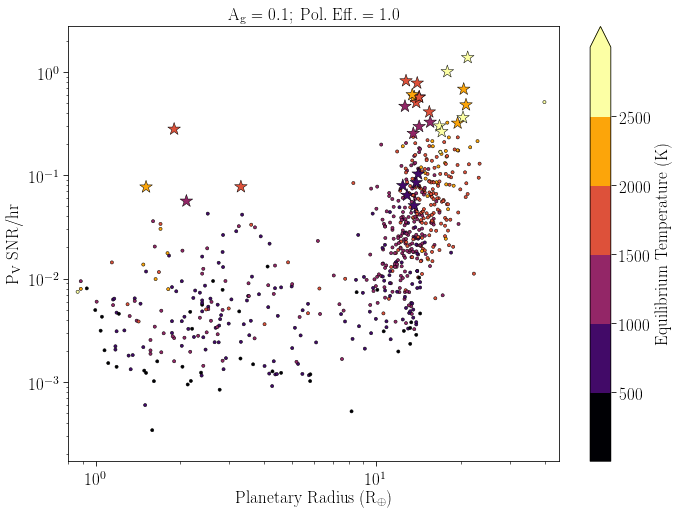

In [9]:
fig = plt.figure(figsize=(11,8))
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(np.nanmin(SNRs[SNRs>0])/2, np.nanmax(SNRs[np.isfinite(SNRs)])*2)
ax.set_xlim(8e-1,45)
ax.set_ylabel(r'$\rm P_'+filt+'~SNR/hr$')
ax.set_xlabel(r'$\rm Planetary~Radius~(R_{\oplus})$')

cmap = plt.get_cmap('inferno', 6)

scat = ax.scatter(x=rps/const.R_earth.value, y=SNRs, c=teq, marker='o', s=10, cmap=cmap, vmin=0, vmax=3000, edgecolor='k', linewidth=0.5)
scat = ax.scatter(x=rps[fullInds]/const.R_earth.value, y=SNRs[fullInds], c=teq[fullInds], marker='*', s=175, cmap=cmap, vmin=0, vmax=3000, edgecolor='k', linewidth=0.5)
cbar = fig.colorbar(scat, ax=ax, label=r'$\rm Equilibrium~Temperature~(K)$', extend='max')
cbar.set_ticks([500,1000,1500,2000,2500])

if albedo != 'theo':
    plt.title(r'$\rm A_g = '+str(albedo)+';~Pol.~Eff. = '+str(polEff)+'$')
else:
    plt.title(r'$\rm Predicted~A_g;~Pol.~Eff. = '+str(polEff)+'$')

plt.savefig('suggestedTargets.pdf', bbox_inches='tight')
plt.show()
plt.close(fig)

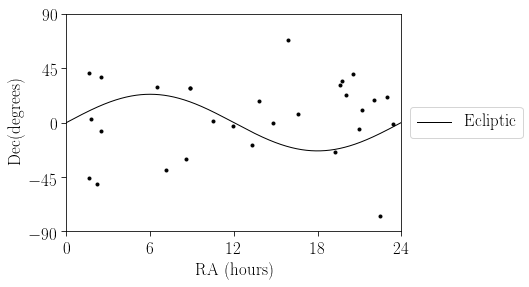

In [10]:
plt.plot(systems.catalogue['ra'][fullInds]*24./360., systems.catalogue['dec'][fullInds], '.', c='k')
x = np.linspace(0,24,1000)
y = 23.43681*np.sin(x*np.pi/12.)
plt.plot(x, y, c='k', lw=1, label=r'$\rm Ecliptic$')
plt.xlabel(r'$\rm RA~(hours)$')
plt.ylabel(r'$\rm Dec (degrees)$')
plt.xticks(np.linspace(0,24,5))
plt.yticks(np.linspace(-90,90,5))
plt.xlim(0,24)
plt.ylim(-90,90)
plt.legend(loc=6, bbox_to_anchor=(1,0.5))
plt.show()

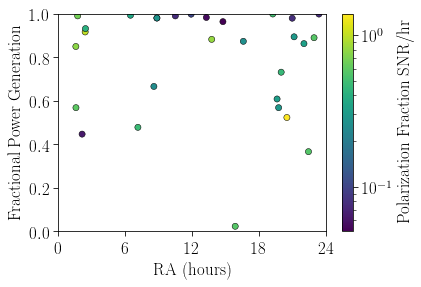

Mean Power Generation: 79% full capacity
Median Power Generation: 89% full capacity


In [11]:
x = systems.catalogue['ra'][fullInds]*24./360.
yEcliptic = 23.43681*np.sin(x*np.pi/12.)
# y = (systems.catalogue['dec'][fullInds] - yEcliptic)
power = np.cos((systems.catalogue['dec'][fullInds] - yEcliptic)*np.pi/180.)

fig = plt.gcf()
ax = plt.gca()

scat = ax.scatter(x=x, y=power, c=SNRs[fullInds], marker='.', s=150, cmap='viridis', norm=colors.LogNorm(), edgecolors='k', linewidth=0.5)
cbar = fig.colorbar(scat, ax=ax, label=r'$\rm Polarization~Fraction~SNR/hr$')
ax.set_xlabel(r'$\rm RA~(hours)$')
ax.set_ylabel(r'$\rm Fractional~Power~Generation$')
ax.set_xticks(np.linspace(0,24,5))
ax.set_xlim(0,24)
ax.set_ylim(0,1)
plt.show()

print('Mean Power Generation: '+str(int(np.rint(np.mean(power)*100)))+'% full capacity')
print('Median Power Generation: '+str(int(np.rint(np.median(power)*100)))+'% full capacity')

In [12]:
np.percentile(power,25)

0.6085073073782649

In [13]:
len(np.where(power>0.8)[0])/len(power)

0.6551724137931034

In [14]:
systems.catalogue['name'][fullInds][np.argmin(power)]

'HD 143105 b'

In [15]:
# Ifull = []
# theta = np.linspace(0,360,100)
# for i in theta:
#     Ifull.append(eppe.rayleigh_scatter(i+90))
# Ifull = np.array(Ifull)



# I = Ifull
# x = I*np.cos(theta*np.pi/180)
# y = I*np.sin(theta*np.pi/180)
# plt.plot(x, y)

# I = 0.75*(1+np.cos(theta*np.pi/180)**2)
# x = I*np.cos(theta*np.pi/180)
# y = I*np.sin(theta*np.pi/180)
# plt.plot(x, y)

# plt.show()